<p align="left">
  <a href="https://colab.research.google.com/github/pydamavand/documentation/blob/main/docs/notebooks/tutorials/classification_demo.ipynb" target="_blank" rel="noopener">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/>
  </a>
</p>

# **Example of Health State Classification**

# Cloning the **damavand** repository

In [ ]:
!git clone https://github.com/pydamavand/damavand

fatal: destination path 'damavand' already exists and is not an empty directory.


In [2]:
!pip install -r damavand/requirements.txt

# Importings

In [23]:
from damavand.damavand.datasets.downloaders import read_addresses, ZipDatasetDownloader
from damavand.damavand.datasets.digestors import SEU
from damavand.damavand.signal_processing import *
from damavand.damavand.utils import *

import pandas as pd
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import LabelEncoder, LabelBinarizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# Instantiating a downloader object

In [4]:
addresses = read_addresses()
downloader = ZipDatasetDownloader(addresses['SEU'])
downloader.download_extract('SEU.zip', 'SEU/')

# Instantiating a digestor object

In [5]:
seu = SEU('SEU/')
mining_params = {
    'win_len': 10000,
    'hop_len': 10000
}
seu.mine(mining_params)

Mining:  Chipped_20_0.csv
Mining:  Miss_20_0.csv
Mining:  Root_30_2.csv
Mining:  Surface_20_0.csv
Mining:  Health_20_0.csv
Mining:  Root_20_0.csv
Mining:  Miss_30_2.csv
Mining:  Health_30_2.csv
Mining:  Chipped_30_2.csv
Mining:  Surface_30_2.csv
Mining:  ball_20_0.csv
Mining:  comb_20_0.csv
Mining:  ball_30_2.csv
Mining:  inner_20_0.csv
Mining:  health_20_0.csv
Mining:  comb_30_2.csv
Mining:  outer_30_2.csv
Mining:  health_30_2.csv
Mining:  inner_30_2.csv
Mining:  outer_20_0.csv


# Aggregating data over the second channel

In [6]:
df = pd.concat(seu.data[1]).reset_index(drop = True)
df

0         1         2         3         4         5         6  \
0     0.000503  0.002112  0.003276  0.002187  0.000864  0.003220 -0.000612   
1     0.003633 -0.000229  0.000552 -0.000004  0.002151  0.003697  0.001304   
2     0.002939 -0.000224  0.000743  0.000638  0.000941  0.004123 -0.001305   
3     0.000901  0.001673  0.000249  0.001255  0.001456  0.000186  0.001425   
4     0.003072  0.000039  0.000633  0.000852 -0.000666  0.001584  0.000923   
...        ...       ...       ...       ...       ...       ...       ...   
2075  0.003477  0.004098 -0.000902  0.002244 -0.000417 -0.000520  0.001959   
2076  0.001140  0.001454  0.002049  0.000772  0.001109 -0.001004 -0.000777   
2077  0.000862 -0.000015  0.000430  0.000468  0.000056  0.001246  0.001090   
2078  0.002031  0.000311  0.000124 -0.002179 -0.001022 -0.000153 -0.001156   
2079  0.000778 -0.002289  0.002877  0.000565 -0.000243  0.002654  0.000502   

             7         8         9  ...      9993      9994      9995  \
0     0.000082  0.000796  0.003134  ... -0.001155  0.000290  0.000763   
1     0.004830  0.004209  0.003994  ...  0.000752 -0.002675  0.002458   
2     0.001551  0.005114  0.000157  ...  0.001551  0.000154  0.001876   
3     0.000232 -0.000758  0.002090  ...  0.001602  0.000980  0.001359   
4     0.002730  0.004590  0.000892  ... -0.002054 -0.002071  0.003704   
...        ...       ...       ...  ...       ...       ...       ...   
2075  0.001307 -0.002608  0.004534  ... -0.000941 -0.001752 -0.000422   
2076  0.000978  0.000858  0.001173  ... -0.000085  0.000597 -0.000103   
2077  0.000552  0.000275 -0.000464  ... -0.001698  0.002050  0.000086   
2078 -0.000972 -0.000298 -0.000947  ...  0.000472 -0.001147  0.001435   
2079 -0.003823  0.002394 -0.001581  ...  0.001876  0.001363 -0.000221   

          9996      9997      9998      9999     test_bed    state  rot_speed  
0    -0.000211  0.002804  0.003674  0.000706     Gear_set  Chipped         20  
1     0.002286 -0.001379  0.002416  0.005218     Gear_set  Chipped         20  
2     0.001844  0.001475  0.001525  0.000941     Gear_set  Chipped         20  
3     0.007073  0.002937  0.004625  0.004481     Gear_set  Chipped         20  
4     0.000231  0.003415  0.005243  0.000980     Gear_set  Chipped         20  
...        ...       ...       ...       ...          ...      ...        ...  
2075 -0.001873 -0.000856  0.001448  0.001341  Bearing_set    outer         20  
2076  0.000166  0.000979  0.000370  0.000114  Bearing_set    outer         20  
2077  0.000114  0.002718  0.000453  0.000899  Bearing_set    outer         20  
2078 -0.000050  0.000645 -0.002612  0.003531  Bearing_set    outer         20  
2079  0.002683  0.003662  0.002092  0.002457  Bearing_set    outer         20  

[2080 rows x 10003 columns]

# Signals-Metadata declaration

In [7]:
signals, metadata = df.iloc[:, : - 3], df.iloc[:, - 3 :]
signals

0         1         2         3         4         5         6     \
0     0.000503  0.002112  0.003276  0.002187  0.000864  0.003220 -0.000612   
1     0.003633 -0.000229  0.000552 -0.000004  0.002151  0.003697  0.001304   
2     0.002939 -0.000224  0.000743  0.000638  0.000941  0.004123 -0.001305   
3     0.000901  0.001673  0.000249  0.001255  0.001456  0.000186  0.001425   
4     0.003072  0.000039  0.000633  0.000852 -0.000666  0.001584  0.000923   
...        ...       ...       ...       ...       ...       ...       ...   
2075  0.003477  0.004098 -0.000902  0.002244 -0.000417 -0.000520  0.001959   
2076  0.001140  0.001454  0.002049  0.000772  0.001109 -0.001004 -0.000777   
2077  0.000862 -0.000015  0.000430  0.000468  0.000056  0.001246  0.001090   
2078  0.002031  0.000311  0.000124 -0.002179 -0.001022 -0.000153 -0.001156   
2079  0.000778 -0.002289  0.002877  0.000565 -0.000243  0.002654  0.000502   

          7         8         9     ...      9990      9991      9992  \
0     0.000082  0.000796  0.003134  ...  0.001869  0.001483  0.000743   
1     0.004830  0.004209  0.003994  ...  0.002317  0.000151 -0.000625   
2     0.001551  0.005114  0.000157  ...  0.001116  0.000269  0.000259   
3     0.000232 -0.000758  0.002090  ...  0.000246 -0.000108  0.001671   
4     0.002730  0.004590  0.000892  ...  0.001267  0.003988  0.002531   
...        ...       ...       ...  ...       ...       ...       ...   
2075  0.001307 -0.002608  0.004534  ... -0.001024 -0.000501 -0.000623   
2076  0.000978  0.000858  0.001173  ...  0.000672  0.000901  0.000944   
2077  0.000552  0.000275 -0.000464  ...  0.000809  0.004516  0.002311   
2078 -0.000972 -0.000298 -0.000947  ...  0.000643  0.000139  0.000671   
2079 -0.003823  0.002394 -0.001581  ...  0.000547  0.001853  0.001171   

          9993      9994      9995      9996      9997      9998      9999  
0    -0.001155  0.000290  0.000763 -0.000211  0.002804  0.003674  0.000706  
1     0.000752 -0.002675  0.002458  0.002286 -0.001379  0.002416  0.005218  
2     0.001551  0.000154  0.001876  0.001844  0.001475  0.001525  0.000941  
3     0.001602  0.000980  0.001359  0.007073  0.002937  0.004625  0.004481  
4    -0.002054 -0.002071  0.003704  0.000231  0.003415  0.005243  0.000980  
...        ...       ...       ...       ...       ...       ...       ...  
2075 -0.000941 -0.001752 -0.000422 -0.001873 -0.000856  0.001448  0.001341  
2076 -0.000085  0.000597 -0.000103  0.000166  0.000979  0.000370  0.000114  
2077 -0.001698  0.002050  0.000086  0.000114  0.002718  0.000453  0.000899  
2078  0.000472 -0.001147  0.001435 -0.000050  0.000645 -0.002612  0.003531  
2079  0.001876  0.001363 -0.000221  0.002683  0.003662  0.002092  0.002457  

[2080 rows x 10000 columns]

In [8]:
metadata

test_bed    state rot_speed
0        Gear_set  Chipped        20
1        Gear_set  Chipped        20
2        Gear_set  Chipped        20
3        Gear_set  Chipped        20
4        Gear_set  Chipped        20
...           ...      ...       ...
2075  Bearing_set    outer        20
2076  Bearing_set    outer        20
2077  Bearing_set    outer        20
2078  Bearing_set    outer        20
2079  Bearing_set    outer        20

[2080 rows x 3 columns]

# Signal Processing

## FFT

In [9]:
window = scipy.signal.windows.hann(signals.shape[1])
freq_filter = scipy.signal.butter(25, [15, 950], 'bandpass', fs = 2000, output='sos')

In [10]:
signals_fft = fft(signals, freq_filter = freq_filter, window = window)
signals_fft.shape

(2080, 5000)

## Statistical Features

In [11]:
signals_features = feature(signals, {'mean': np.mean, 'var': np.var, 'rms': rms, 'skew': skew, 'kurtosis': kurtosis})
signals_features.shape

(2080, 5)

# Health classification task

## Target declaration

In [12]:
y = metadata['state']
le = LabelEncoder()
y_encoded = le.fit_transform(y)
np.unique(y_encoded, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([208, 208, 208, 208, 208, 208, 208, 208, 208, 208]))

In [13]:
lb = LabelBinarizer()
y_bin = lb.fit_transform(y_encoded)

## Train-test split

In [14]:
x_fft_train, x_fft_test, x_features_train, x_features_test, y_encoded_train, y_encoded_test, y_bin_train, y_bin_test = train_test_split(signals_fft, signals_features, y_encoded, y_bin, test_size=0.33, random_state=42)

## Training

### Classic machine learning

In [15]:
DT = DecisionTreeClassifier()
DT.fit(x_features_train, y_encoded_train)

DecisionTreeClassifier()

### Deep Learning

In [16]:
def model_creator():

  input = Input(shape = (5000,), name='input1')
  e = Dense(units = 2500, activation='tanh', name = 'HL1')(input)
  predicted_label = Dense(units = 10, activation='softmax', name='label')(e)

  return Model(inputs = input, outputs = predicted_label)

In [17]:
scaler = MinMaxScaler()
x_fft_train_scaled = scaler.fit_transform(x_fft_train)
x_fft_test_scaled = scaler.transform(x_fft_test)

In [18]:
lr = 0.0001
ep = 25

model = model_creator()
opt = optimizers.Adam(learning_rate=lr, decay=lr / ep)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

histories  = model.fit(x_fft_train_scaled, y_bin_train, validation_split=0.25, epochs = ep, batch_size = 250)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 737ms/step - accuracy: 0.1329 - loss: 2.5406 - val_accuracy: 0.2636 - val_loss: 1.9598
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 412ms/step - accuracy: 0.2904 - loss: 1.8779 - val_accuracy: 0.6017 - val_loss: 1.4486
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 405ms/step - accuracy: 0.6108 - loss: 1.3780 - val_accuracy: 0.7593 - val_loss: 1.1201
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 407ms/step - accuracy: 0.8138 - loss: 1.0299 - val_accuracy: 0.9828 - val_loss: 0.8795
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 407ms/step - accuracy: 0.9521 - loss: 0.8040 - val_accuracy: 0.9628 - val_loss: 0.7117
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step - accuracy: 0.9742 - loss: 0.6438 - val_accuracy: 0.9857 - val_loss: 0.5797
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 408ms/step - accuracy: 0.9917 - loss: 0.4939 - val_accuracy: 1.0000 - val_loss: 0.4681
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 408ms/step - accuracy: 1.0000 - loss: 0.4052 - val_accuracy: 1.0000 - val_loss: 0.4004
Epo

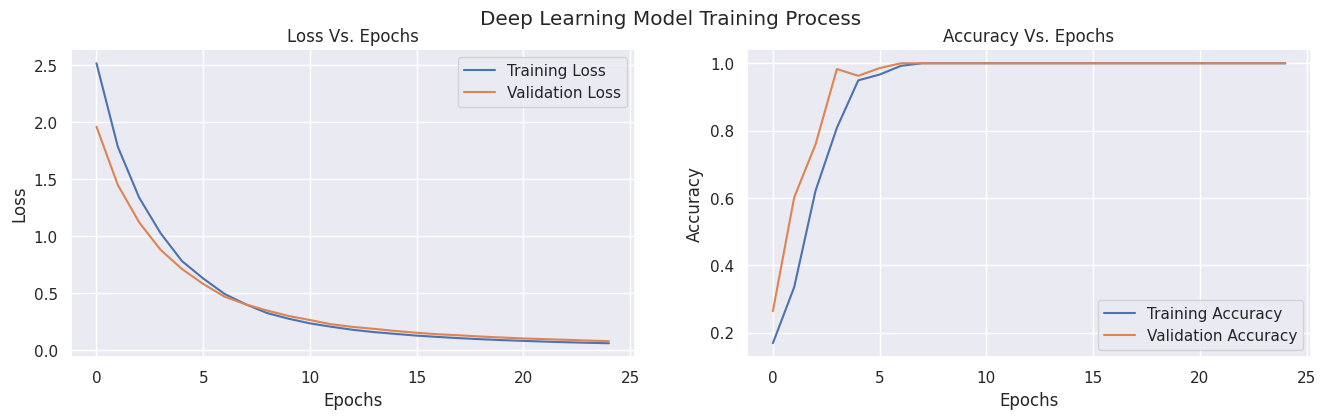

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16,4))
fig.suptitle('Deep Learning Model Training Process')
axes[0].plot(histories.history['loss'], label='Training Loss')
axes[0].plot(histories.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Vs. Epochs')
axes[0].legend()

axes[1].plot(histories.history['accuracy'], label='Training Accuracy')
axes[1].plot(histories.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Vs. Epochs')
axes[1].legend()
plt.show()

## Evaluation

In [21]:
y_train_pred_DT = DT.predict(x_features_train)
y_test_pred_DT = DT.predict(x_features_test)
y_train_pred_DL = np.argmax(model.predict(x_fft_train_scaled), axis = 1)
y_test_pred_DL = np.argmax(model.predict(x_fft_test_scaled), axis = 1)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


### Accuracies

In [22]:
print('Decision tree training accuracy: ', np.round(accuracy_score(y_encoded_train, y_train_pred_DT), 4))
print('Decision tree testing accuracy: ', np.round(accuracy_score(y_encoded_test, y_test_pred_DT), 4))
print('Deep learnign model training accuracy: ', np.round(accuracy_score(y_encoded_train, y_train_pred_DL), 4))
print('Deep learnign model testing accuracy: ', np.round(accuracy_score(y_encoded_test, y_test_pred_DL),  4))

Decision tree training accuracy:  1.0
Decision tree testing accuracy:  0.8195
Deep learnign model training accuracy:  1.0
Deep learnign model testing accuracy:  1.0


### Confusion Matrices

In [24]:
confusion_matrix_DT = confusion_matrix(y_encoded_test, y_test_pred_DT)
confusion_matrix_DL = confusion_matrix(y_encoded_test, y_test_pred_DL)

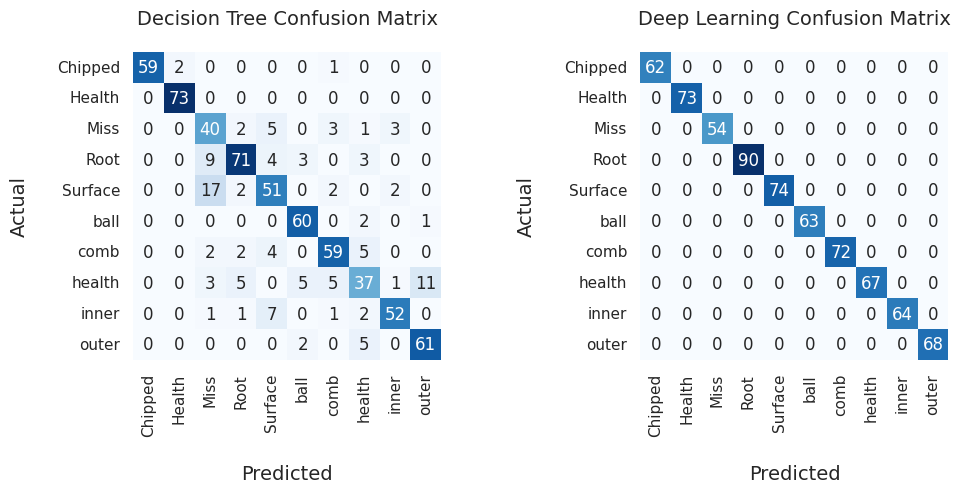

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.heatmap(confusion_matrix_DT, annot=True, square = True, cmap='Blues', fmt='g', cbar = False, ax=axes[0])
axes[0].set_xlabel("Predicted", fontsize=14, labelpad=20)
axes[0].xaxis.set_ticklabels(le.classes_)
axes[0].set_ylabel("Actual", fontsize=14, labelpad=20)
axes[0].yaxis.set_ticklabels(le.classes_)
axes[0].set_title("Decision Tree Confusion Matrix", fontsize=14, pad=20)
axes[0].tick_params(axis='x', rotation=90)
axes[0].tick_params(axis='y', rotation=360)

sns.heatmap(confusion_matrix_DL, annot=True, square = True, cmap='Blues', fmt='g', cbar = False, ax=axes[1])
axes[1].set_xlabel("Predicted", fontsize=14, labelpad=20)
axes[1].xaxis.set_ticklabels(le.classes_)
axes[1].set_ylabel("Actual", fontsize=14, labelpad=20)
axes[1].yaxis.set_ticklabels(le.classes_)
axes[1].set_title("Deep Learning Confusion Matrix", fontsize=14, pad=20)
axes[1].tick_params(axis='x', rotation=90)
axes[1].tick_params(axis='y', rotation=360)

plt.show()